# COVID-19 in NSW

This project aims to analyse NSW Health's data about reported COVID-19 cases in NSW, to uncover any patterns or trends. In this project, I will clean, query, visualise and explain findings from the analysis.

Please see the [README](https://github.com/henrylin03/covid-nsw) for more information.

#### Data Source

[NSW COVID-19 cases by location](https://data.nsw.gov.au/search/dataset/ds-nsw-ckan-aefcde60-3b0c-4bc0-9af1-6fe652944ec2/details?q=) is published by NSW Health.


## Setup


Create SQL engine and load input CSV into a SQLite table:


In [1]:
from glob import glob
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine("sqlite://", echo=False)

covid_df = pd.read_csv(glob("./input/confirmed_cases*.csv")[0])
covid_df.to_sql("covid", engine, if_exists="replace", index=False)
covid_df.head(3)


,notification_date,postcode,lhd_2010_code,lhd_2010_name,lga_code19,lga_name19,confirmed_by_pcr,confirmed_cases_count
0,2020-01-25,2071,X760,Northern Sydney,14500,Ku-ring-gai (A),NaN,1
1,2020-01-25,2121,X760,Northern Sydney,16260,Parramatta (C),NaN,1
2,2020-01-25,2134,X700,Sydney,11300,Burwood (A),NaN,1


## Cleaning

The dataset is prepared for analysis by inspecting and cleaning, where appropriate.


### Removing suffix to LGAs

In the `lga_name19` column, some Local Government Areas (LGAs) have bracketed suffixes:

1. `(A)` and `(C)`: remove as do not appear to have significance in distinguishing LGAs. NSW Health did not provide guidance in the [dataset's dictionary](https://data.nsw.gov.au/data/dataset/covid-19-cases-by-location/resource/5d63b527-e2b8-4c42-ad6f-677f14433520) nor elsewhere.
2. `(NSW)`: remove as all LGAs are within NSW.

I will remove using SQL's `REPLACE()` function, and add to a new column "`lga`":


In [2]:
covid_lga_cleaned = pd.read_sql_query(
    """
        SELECT *,
            REPLACE(
                REPLACE(
                    REPLACE(
                        lga_name19, ' (A)', ''
                    ), ' (C)', ''
                ), ' (NSW)', ''
            ) AS 'lga'
        FROM covid
    """,
    engine,
)

covid_lga_cleaned.to_sql("covid", engine, if_exists="replace", index=False)
covid_lga_cleaned.head(3)


,notification_date,postcode,lhd_2010_code,lhd_2010_name,lga_code19,lga_name19,confirmed_by_pcr,confirmed_cases_count,lga
0,2020-01-25,2071,X760,Northern Sydney,14500,Ku-ring-gai (A),None,1,Ku-ring-gai
1,2020-01-25,2121,X760,Northern Sydney,16260,Parramatta (C),None,1,Parramatta
2,2020-01-25,2134,X700,Sydney,11300,Burwood (A),None,1,Burwood


### Missing

There are missing values in both `postcode` and `confirmed_by_pcr` columns:


In [3]:
pd.read_sql_query(
    """
    SELECT SUM(CASE WHEN notification_date IS NULL THEN 1 ELSE 0 END) AS 'nd_miss',
        SUM(CASE WHEN postcode IS 'None' THEN 1 ELSE 0 END) AS 'pc_miss',
        SUM(CASE WHEN lhd_2010_code IS  NULL THEN 1 ELSE 0 END) AS 'lhdc_miss',
        SUM(CASE WHEN lhd_2010_name IS NULL THEN 1 ELSE 0 END) AS 'lhdn_miss',
        SUM(CASE WHEN lga_code19 IS NULL THEN 1 ELSE 0 END) AS 'lgac_miss',
        SUM(CASE WHEN lga_name19 IS NULL THEN 1 ELSE 0 END) AS 'lgan_miss',
        SUM(CASE WHEN confirmed_by_pcr IS NULL THEN 1 ELSE 0 END) AS 'pcr_miss',
        SUM(CASE WHEN confirmed_cases_count IS NULL THEN 1 ELSE 0 END) AS 'confirmed_cases_miss',
        SUM(CASE WHEN lga IS NULL THEN 1 ELSE 0 END) AS 'lga_miss'
    FROM covid
""",
    engine,
)


,nd_miss,pc_miss,lhdc_miss,lhdn_miss,lgac_miss,lgan_miss,pcr_miss,confirmed_cases_miss,lga_miss
0,0,573,0,0,0,0,41079,0,0


However, these are both difficult to impute:

- `postcode`: although Local Government Area (LGA) information is not missing for rows with missing `postcode`, LGA to postcode's relationship is M:M. There can be multiple postcodes in an LGA (eg [Georges River has 6 postcodes](https://www.worldpostalcodes.org/l1/en/au/australia/map/r2/map-of-postcodes-in-georges-river)), and a postcode can be in multiple LGAs (eg [2153 (Baulkham Hills) is in both The Hills and Parramatta LGAs](https://en.wikipedia.org/wiki/Baulkham_Hills,_New_South_Wales).

- `confirmed_by_pcr` records whether a case detected by Rapid Antigen Tests (RAT) was also confirmed by PCR. All missing values were prior to 19 Jan 2022 (_see below_) and would be difficult to impute.


In [4]:
pd.read_sql_query(
    """
        SELECT MAX(notification_date) AS 'latest_pcr_miss_date'
        FROM covid
        WHERE confirmed_by_pcr IS NULL
    """,
    engine,
)


,latest_pcr_miss_date
0,2022-01-19


## Analysis

In this section, I use SQL queries and Python visualisations to highlight insights in the data.


### Daily cases have trended upwards

Since reporting started on 25 Jan 2020, daily cases have trended upwards, **peaking in Jan 2022**, and then to a lesser peak in Mar 2022.


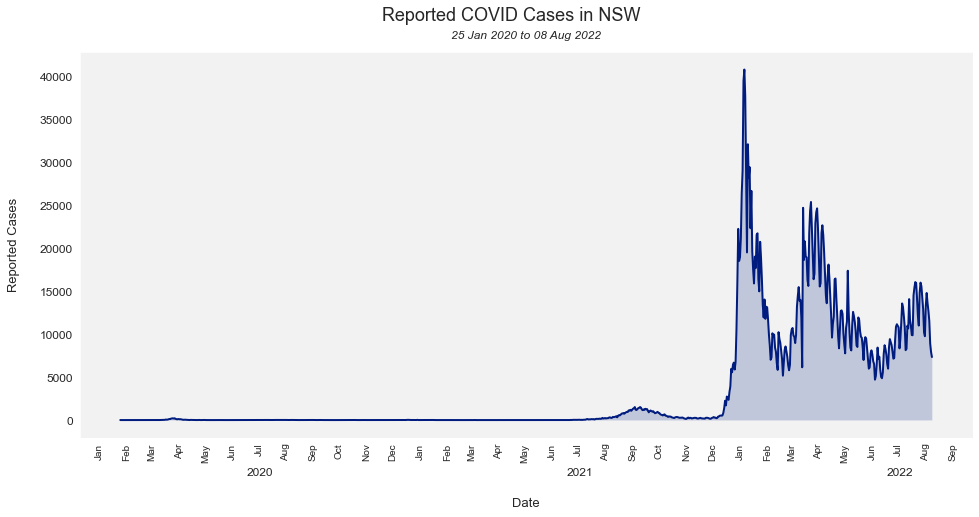

<Figure size 432x288 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns

# querying
daily_cases = pd.read_sql_query(
    """
        SELECT DATE(notification_date) AS 'date',
            SUM(confirmed_cases_count) AS 'reported_cases'
        FROM covid
        GROUP BY 1
    """,
    engine,
)

# transforming and extracting from DataFrame for visualisation
daily_cases["date"] = pd.to_datetime(daily_cases["date"], format="%Y-%m-%d")
start_date = daily_cases.date.min().strftime("%d %b %Y")
end_date = daily_cases.date.max().strftime("%d %b %Y")

# plotting visualisation
sns.set_style("dark", {"axes.facecolor": "0.95"})
sns.set_palette("dark")

fig, ax = plt.subplots(figsize=(16, 7))
sns.lineplot(x="date", y="reported_cases", data=daily_cases, ax=ax, linewidth=2)
plt.fill_between(x=daily_cases["date"], y1=daily_cases["reported_cases"], alpha=0.2)

# setting x-axis ticks
ax.xaxis.set_minor_locator(md.MonthLocator(bymonth=range(13)))
ax.xaxis.set_minor_formatter(md.DateFormatter("%b"))
ax.xaxis.set_major_locator(md.YearLocator(month=7, day=2))
ax.xaxis.set_major_formatter(md.DateFormatter("\n\n%Y"))
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
ax.tick_params(axis="both", labelsize=12)

# modifying line-chart parameters
ax.figure.suptitle("Reported COVID Cases in NSW", fontsize=18)
ax.set_title(f"{start_date} to {end_date}", y=1.02, style="italic")
ax.set_xlabel("Date", fontsize=13, labelpad=20)
ax.set_ylabel("Reported Cases", fontsize=13, labelpad=20)

fig.subplots_adjust(top=0.89)

plt.show()
plt.clf()


#### Cases peaked in Jan 2022, and then in Mar 2022...

The **top 10 daily cases all occurred in _Jan 2022_**. 11th to 16th are part of the Mar 2022 spike.


In [6]:
pd.read_sql_query(
    """
    SELECT
        RANK() OVER (
            ORDER BY SUM(confirmed_cases_count) DESC
        ) AS 'rank',
        DATE(notification_date) AS 'date',
        STRFTIME('%m-%Y', notification_date) AS 'month_year',
        SUM(confirmed_cases_count) AS 'reported_cases'
    FROM covid
    GROUP BY 2
    ORDER BY 4 DESC
    LIMIT 20
""",
    engine,
)


,rank,date,month_year,reported_cases
0,1,2022-01-06,01-2022,40752
1,2,2022-01-05,01-2022,39431
2,3,2022-01-07,01-2022,37676
3,4,2022-01-10,01-2022,32070
4,5,2022-01-12,01-2022,29411
5,6,2022-01-04,01-2022,29031
6,7,2022-01-08,01-2022,28174
7,8,2022-01-11,01-2022,28137
8,9,2022-01-14,01-2022,26646
9,10,2022-01-03,01-2022,26374


#### Cases typically peak mid-week, decreasing into the weekend, then rebounding on Mondays...

Over the reporting period, average daily cases tend to increase after the weekend, **peaking on Wednesdays** (daily average = 14.9 cases), before **reducing into the weekend until Sundays** (daily average = 11 cases).


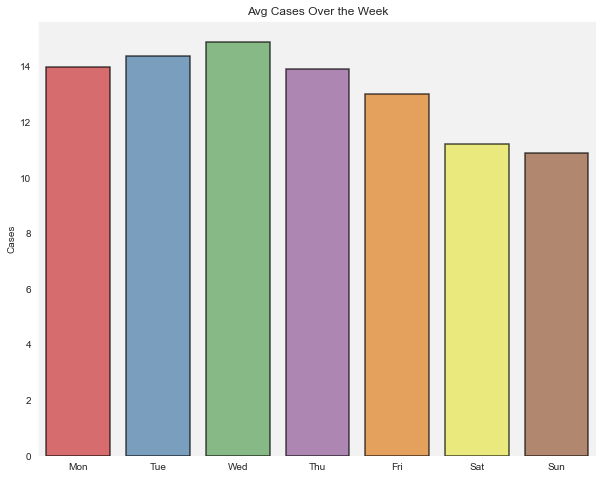

,day_of_wk,cases_avg
1,Mon,14.0
2,Tue,14.4
3,Wed,14.9
4,Thu,13.9
5,Fri,13.0
6,Sat,11.2
0,Sun,10.9


<Figure size 432x288 with 0 Axes>

In [7]:
days_of_wk = pd.read_sql_query(
    """
    SELECT
        SUBSTR(
            'SunMonTueWedThuFriSat',
            1 + 3 * STRFTIME('%w', notification_date), 3
        ) AS 'day_of_wk',
        ROUND(
            AVG(confirmed_cases_count), 1
        ) AS 'cases_avg'
    FROM covid
    GROUP BY 1
    ORDER BY STRFTIME('%w', notification_date)
""",
    engine,
)

# Ordering by STRFTIME('%w') would start the week on Sunday instead of Monday
days_of_wk["day_of_wk"] = pd.Categorical(
    days_of_wk.day_of_wk,
    ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    ordered=True,
)
days_of_wk.sort_values("day_of_wk", inplace=True)

# Plotting
sns.set_palette("Set1", 7)

fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(
    data=days_of_wk,
    x="day_of_wk",
    y="cases_avg",
    edgecolor="black",
    linewidth=1.5,
    ax=ax,
    alpha=0.7,
).set(xlabel=None, ylabel="Cases", title="Avg Cases Over the Week")

plt.show()
plt.clf()

display(days_of_wk)


### "Zero" days

Days without any COVID-19 cases were more frequent at the beginning of the reporting period. **Feb 2020 was an entire _month_ of zero days.**


In [8]:
zero_days_df = pd.read_sql_query(
    """
        WITH RECURSIVE dates(date) AS (
            VALUES((
                SELECT MIN(notification_date)
                FROM covid
                )
            )
            UNION ALL
            SELECT DATE(date, '+1 day')
            FROM dates
            WHERE date < (
                SELECT MAX(notification_date)
                FROM covid
                )
            )

        SELECT
            d.*
        FROM dates d
        LEFT JOIN covid c
            ON c.notification_date = d.date
        WHERE c.notification_date IS NULL
        ORDER BY 1
        """,
    engine,
)

zero_days_df.to_sql("zero_days", engine, if_exists="replace", index=False)
zero_days_df


,date
0,2020-01-26
1,2020-01-28
2,2020-01-29
3,2020-01-30
4,2020-01-31
...,...
86,2021-05-31
87,2021-06-01
88,2021-06-03
89,2021-06-11


In [9]:
pd.read_sql_query(
    """
    SELECT 
        STRFTIME('%Y-%m', date) AS 'year_month',
        COUNT(*) AS 'zero_days_count'
    FROM zero_days
    GROUP BY 1
    ORDER BY 1
""",
    engine,
)


,year_month,zero_days_count
0,2020-01,5
1,2020-02,29
2,2020-05,9
3,2020-06,4
4,2020-09,3
5,2020-10,1
6,2020-11,3
7,2021-01,7
8,2021-02,10
9,2021-03,6


#### Days since the last "zero" day

As of the latest date in the dataset, the days since the last "zero day" is...


In [10]:
from IPython.display import Markdown
import numpy as np

last_zeroday = pd.to_datetime(zero_days_df.date.max())
days_since_zero = round(
    (daily_cases.date.max() - last_zeroday) / np.timedelta64(1, "D")
)

display(
    Markdown(
        f"""
<h1 align='center'>{days_since_zero}</h1>
<div align='center'><br>days since the last COVID-zero day</div>"""
    )
)



<h1 align='center'>422</h1>
<div align='center'><br>days since the last COVID-zero day</div>

#### The longest streak of "zero" days was 33 days

Since reporting began 25 Jan 2020, the longest streak began on 28 Jan 2020, and lasted until 1 Mar 2020.

Conscious testing rates were likely low as [Australia only reported its first COVID case on 25 Jan 2020](https://www.health.gov.au/ministers/the-hon-greg-hunt-mp/media/first-confirmed-case-of-novel-coronavirus-in-australia), the second longest streak of 4 days began on 11 Feb 2021, and lasted until 15 Feb 2021:


In [11]:
# I minus 1 day from the difference between two dates where there were 1+ reported cases,
# as the calculation includes the day that breaks the streak (and has 1+ reported cases)

zd_streaks = pd.read_sql_query(
    """
        WITH daily_cases AS (
            SELECT 
                DATE(notification_date) AS 'date',
                SUM(confirmed_cases_count) AS 'reported_cases'
            FROM covid
            GROUP BY 1
        )

        SELECT *
        FROM (
            SELECT 
                date AS 'date_streak_broken', 
                ROUND(
                    JULIANDAY(date) 
                    - JULIANDAY(
                            LAG(date) OVER (
                                ORDER BY date
                            )
                    )
                - 1) AS 'streaks'
            FROM daily_cases
        )
        WHERE streaks > 0
        ORDER BY streaks DESC
    """,
    engine,
)

# `date_diff` = 0 is filtered out as these mean no zero days in between those dates

zd_streaks["streaks"] = zd_streaks["streaks"].astype(int)

zd_streaks


,date_streak_broken,streaks
0,2020-03-01,33
1,2021-02-15,4
2,2020-05-18,3
3,2021-06-02,3
4,2020-05-12,2
5,2020-05-28,2
6,2020-06-17,2
7,2020-09-28,2
8,2021-01-23,2
9,2021-02-03,2


#### Most "zero" days were not consecutive

Examining the right-skewed distribution of "zero" day streaks, **72% of "zero" days were non-consecutive.** The 33-day streak, at the beginning of 2020, is an _outlier_ within the dataset.


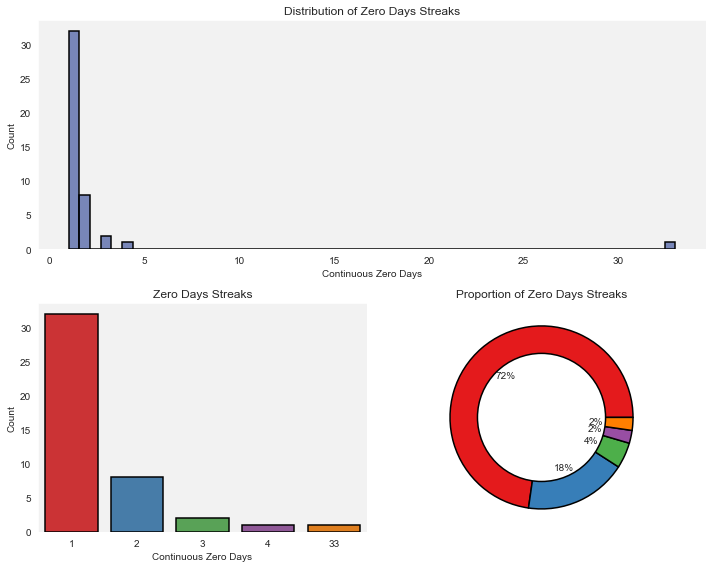

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(2, 2)
f = plt.figure(figsize=(10, 8))

# histogram for distribution
sns.set_palette("dark")
zd_hist = f.add_subplot(gs[:-1, :])
sns.histplot(
    data=zd_streaks,
    x="streaks",
    alpha=0.5,
    legend=False,
    edgecolor="black",
    linewidth=1.5,
).set(xlabel="Continuous Zero Days", title="Distribution of Zero Days Streaks")

# countplot for distribution
sns.set_palette("Set1")
zd_countp = f.add_subplot(gs[1, 0])
sns.countplot(data=zd_streaks, x="streaks", edgecolor="black", linewidth=1.5).set(
    xlabel="Continuous Zero Days", ylabel="Count", title="Zero Days Streaks"
)

# donut chart for proportion
zd_prop = f.add_subplot(gs[1, 1])
## transforming table for donut chart generation
zd_streaks_count = (
    zd_streaks.groupby("streaks")
    .count()
    .reset_index()
    .rename(columns={"date_streak_broken": "date_diff_count"})
)
zd_donut = plt.pie(
    zd_streaks_count["date_diff_count"],
    wedgeprops={"linewidth": 1.5, "edgecolor": "black"},
    autopct="%d%%",
)
plt.title("Proportion of Zero Days Streaks")

my_circle = plt.Circle((0, 0), 0.7, facecolor="white", edgecolor="black", linewidth=1.5)
p = plt.gcf()
p.gca().add_artist(my_circle)


gs.tight_layout(f)
plt.show()
plt.clf()


#### "Zero" days occur slightly more on Saturdays...

"Zero" days are approximately the same over the week. 18% of "zero" days occurred on Saturdays (16 times).


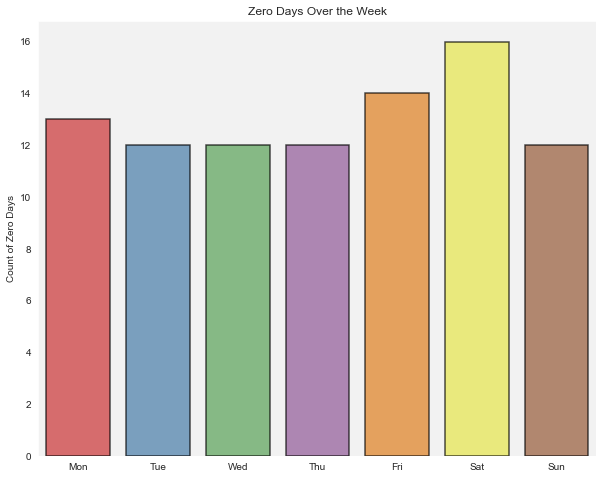

,day_of_wk,zero_days_count,proportion
0,Mon,13,0.14
1,Tue,12,0.13
2,Wed,12,0.13
3,Thu,12,0.13
4,Fri,14,0.15
5,Sat,16,0.18
6,Sun,12,0.13


<Figure size 432x288 with 0 Axes>

In [13]:
zd_days_of_wk = pd.read_sql_query(
    """
    SELECT
        SUBSTR(
            'SunMonTueWedThuFriSat',
            1 + 3 * STRFTIME('%w', date), 3
        ) AS 'day_of_wk',
        COUNT(*) AS 'zero_days_count',
        ROUND(
            1.0 * COUNT(*) / (
                SELECT COUNT(*)
                FROM zero_days
            ), 2) AS proportion
    FROM zero_days
    GROUP BY 1
    ORDER BY STRFTIME('%w', date)
""",
    engine,
)

zd_days_of_wk["day_of_wk"] = pd.Categorical(
    days_of_wk.day_of_wk,
    ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    ordered=True,
)
zd_days_of_wk.sort_values("day_of_wk", inplace=True)

# Plotting
sns.set_palette("Set1", 7)
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(
    data=zd_days_of_wk,
    x="day_of_wk",
    y="zero_days_count",
    edgecolor="black",
    linewidth=1.5,
    ax=ax,
    alpha=0.7,
).set(xlabel=None, ylabel="Count of Zero Days", title="Zero Days Over the Week")

plt.show()
plt.clf()

display(zd_days_of_wk)


### Location


#### _Blacktown_ LGA has had the highest number of reported cases in NSW

...with 160,000+ cases to date.

_Unincorporated NSW_ LGA has the lowest count with < 100 cases since reporting started. "Hotel Quarantine" is not an LGA and is excluded from ranking.


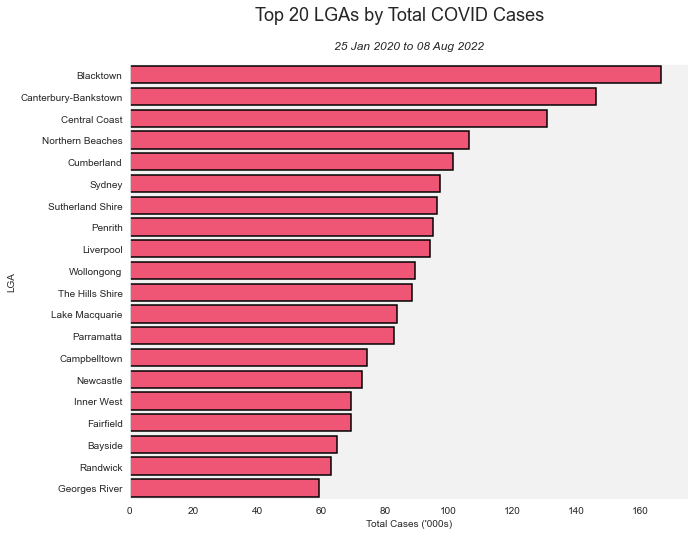

LGAs by total COVID cases from 25 Jan 2020 to 08 Aug 2022:


,lga,total_cases,avg_daily_cases
0,Blacktown,166528,179
1,Canterbury-Bankstown,146216,157
2,Central Coast,130673,141
3,Northern Beaches,106312,114
4,Cumberland,101293,109
...,...,...,...
126,Central Darling,600,0
127,Carrathool,433,0
128,Brewarrina,408,0
129,Unincorporated NSW,82,0


<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.ticker as ticker

lga_cases_total = pd.read_sql_query(
    """
        SELECT lga, 
            SUM(confirmed_cases_count) AS 'total_cases',
            CAST(
                1.0 * SUM(confirmed_cases_count) / (
                    SELECT JULIANDAY(MAX(notification_date)) -
                        JULIANDAY(MIN(notification_date))
                    FROM covid
                )
            AS INT) AS 'avg_daily_cases'
        FROM covid
        GROUP BY 1
        ORDER BY 2 DESC
    """,
    engine,
)

fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(
    x="total_cases",
    y="lga",
    data=lga_cases_total.head(20),
    orient="h",
    saturation=8,
    color="#ef5675",
    edgecolor="black",
    linewidth=1.5,
    ax=ax,
).set(xlabel="Total Cases ('000s)", ylabel="LGA")
ax.figure.suptitle("Top 20 LGAs by Total COVID Cases", fontsize=18)
ax.set_title(f"{start_date} to {end_date}", y=1.02, style="italic")
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x / 1000))
)


plt.show()
plt.clf()
print(f"LGAs by total COVID cases from {start_date} to {end_date}:")
lga_cases_total


Looking by map...


#### Unincorporated NSW was the "last LGA standing"

_Unincorporated NSW_ LGA did not have any reported cases until 4 Jan 2022, almost two years after the first case was reported in NSW. It was the last LGA to report its first COVID case. Just behind, Bland & Carrathool, both in the Riverina region, did not report their first case until 25 Dec 2021.

Contrastingly, Parramatta, Ku-ring-gai & Burwood reported the first COVID cases on day one of reporting.


In [15]:
pd.read_sql_query(
    """
    SELECT
        FIRST_VALUE(notification_date) OVER (
            PARTITION BY lga
            ORDER BY notification_date
            RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
        ) AS 'date_first_case',
        lga
    FROM covid
    GROUP BY 2
    ORDER BY 1 DESC
""",
    engine,
)


,date_first_case,lga
0,2022-01-04,Unincorporated NSW
1,2021-12-25,Bland
2,2021-12-25,Carrathool
3,2021-12-23,Coolamon
4,2021-12-21,Leeton
...,...,...
126,2020-03-01,Hornsby
127,2020-01-27,Randwick
128,2020-01-25,Burwood
129,2020-01-25,Ku-ring-gai


#### Cases over time in LGAs

In [16]:
from datetime import datetime

daily_by_lga = pd.read_sql_query(
    """
        SELECT DATE(notification_date) AS 'date',
            lga,
            SUM(confirmed_cases_count) AS 'daily_cases'
        FROM covid
        WHERE lga COLLATE NOCASE NOT IN (
            'hotel quarantine', 'correctional settings'
        )
        GROUP BY lga, date
    """, engine)

daily_by_lga["date"] = pd.to_datetime(daily_by_lga["date"], format="%Y-%m-%d")

    
def plot_and_colour_lga(lga_name, line_colour, year_month=None):
    filtered_df = filter_by_lga_and_month(lga_name)[0]
    year_month_formatted = filter_by_lga_and_month(lga_name, year_month)[1]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax = sns.lineplot(
        x="date", y="daily_cases",
        data=daily_by_lga,
        hue="lga",
        palette=sns.color_palette([".7"], len(daily_by_lga.lga.unique())),
        legend=False,
        linewidth=0.2
    )
    ax = sns.lineplot(
        x="date", y="daily_cases",
        data=filtered_df,
        color=f"{line_colour}",
        linewidth=2,
        alpha=0.8,
    )
    
    # format figure labels
    ax.figure.suptitle(f"Reported COVID Cases in {lga_name} LGA", fontsize=18)
    ax.set_title(f"{start_date} to {end_date}", y=1.02, style="italic")
    ax.set_ylabel("Reported Cases", fontsize=13, labelpad=20)
    fig.subplots_adjust(top=0.89)
    
    # format x-axis ticks and tick labels
    ax.xaxis.set_minor_locator(md.MonthLocator(bymonth=range(13)))
    ax.xaxis.set_minor_formatter(md.DateFormatter("%b"))
    ax.xaxis.set_major_locator(md.YearLocator(month=7, day=2)) # this ensures the year label is in the centre
    ax.xaxis.set_major_formatter(md.DateFormatter("\n\n%Y"))
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
    ax.tick_params(axis="both", labelsize=12)
    
    plt.show()
    plt.clf()
    
    # display DataFrame, with optional `year_month` filtering
    date_filtered_print = f" in {year_month_formatted}" if year_month is not None else ""
    print(f"{lga_name} LGA's highest daily cases{date_filtered_print}:")
  
    display(filter_by_lga_and_month(lga_name, year_month)[0]
                .sort_values("daily_cases", ascending=False)\
                .reset_index(drop=True))

def filter_by_lga_and_month(lga_name, year_month=None):
    filtered_df = daily_by_lga[daily_by_lga.lga == lga_name]
    if year_month is None:
        return filtered_df, ""
    else:
        year_month_formatted = datetime.strptime(year_month, "%Y-%m").strftime("%b %Y")
        date_filtered_df = filtered_df[filtered_df.date.dt.strftime("%Y-%m")==year_month]
        return date_filtered_df, year_month_formatted

##### Since the first "Omicron" wave, Blacktown LGA has largely led daily cases...
As the leader of daily cases, Blacktown LGA has consistently had high reported cases throughout the reporting period. Since the "Omicron" wave in early 2022, Blacktown LGA has mostly led reported cases, peaking on 6 Jan 2022 with 2800+ daily cases.

But, during the "Delta" wave in Sep/Oct 2021, Blacktown LGA was not the leader in reported cases...

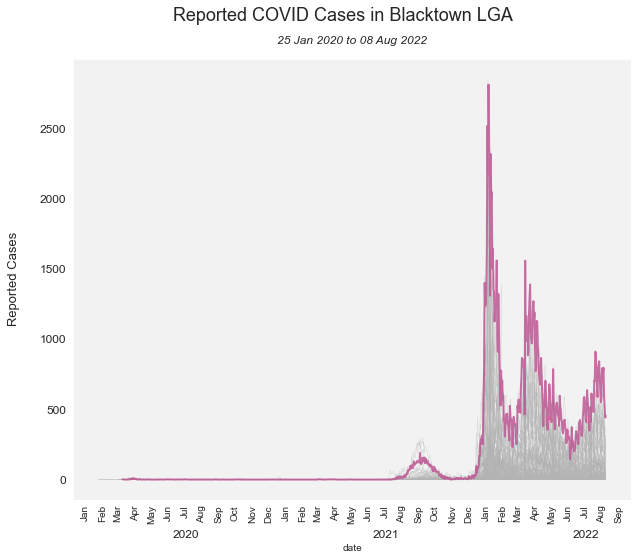

Blacktown LGA's highest daily cases:


,date,lga,daily_cases
0,2022-01-06,Blacktown,2815
1,2022-01-04,Blacktown,2521
2,2022-01-07,Blacktown,2506
3,2022-01-10,Blacktown,2321
4,2022-01-05,Blacktown,2183
...,...,...,...
520,2020-12-20,Blacktown,1
521,2021-07-08,Blacktown,1
522,2020-12-23,Blacktown,1
523,2020-12-26,Blacktown,1


<Figure size 432x288 with 0 Axes>

In [17]:
plot_and_colour_lga("Blacktown", "#bc5090")

##### During the "Delta" wave, Canterbury-Bankstown largely led daily cases...

Canterbury-Bankstown was leading daily cases during NSW's "Delta" variant wave in Aug to Oct 2021, peaking at 302 cases on 8 Sep 2021. 

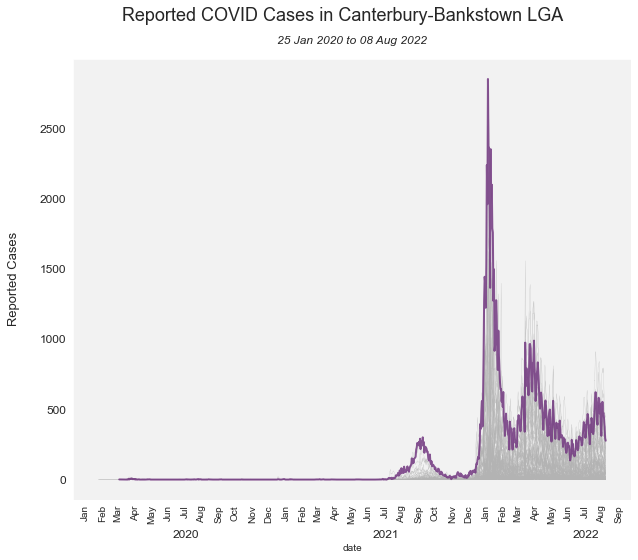

Canterbury-Bankstown LGA's highest daily cases in Sep 2021:


,date,lga,daily_cases
0,2021-09-08,Canterbury-Bankstown,302
1,2021-09-03,Canterbury-Bankstown,292
2,2021-09-05,Canterbury-Bankstown,275
3,2021-09-01,Canterbury-Bankstown,269
4,2021-09-10,Canterbury-Bankstown,268
5,2021-09-06,Canterbury-Bankstown,263
6,2021-09-07,Canterbury-Bankstown,263
7,2021-09-02,Canterbury-Bankstown,241
8,2021-09-09,Canterbury-Bankstown,241
9,2021-09-12,Canterbury-Bankstown,235


<Figure size 432x288 with 0 Axes>

In [19]:
plot_and_colour_lga("Canterbury-Bankstown", "#6d2f7c", "2021-09")

During the period from when the "limo driver" - ["patient zero" of Sydney's Delta outbreak](https://www.smh.com.au/national/nsw/sydney-limo-driver-couldn-t-cope-with-the-stress-after-sparking-covid-outbreak-lockdown-20220623-p5avzg.html) - was likely infectious in the community ([11 Jun 2021](https://www.abc.net.au/news/2021-06-17/nsw-quarantine-worker-may-have-breached-health-order/100223120)), until the [107-day lockdown ending on 11 Oct 2021](https://www.bbc.com/news/world-australia-58866464), Canterbury-Bankstown topped >50% of those days with its daily case numbers.

Canterbury-Bankstown topped far more days with its daily cases during  than Cumberland and Fairfield LGAs 

In [90]:
pd.read_sql_query(
    """WITH lga_with_top_daily_cases_delta AS (
            SELECT DATE(date) AS 'date',
                lga,
                MAX(daily_cases) AS 'max_daily_cases'
            FROM (
                SELECT DATE(notification_date) AS 'date',
                    lga,
                    SUM(confirmed_cases_count) AS 'daily_cases'
                FROM covid
                GROUP BY lga, date
            )
            WHERE lga COLLATE NOCASE NOT IN (
                'hotel quarantine', 'correctional settings'
            ) AND
                DATE(date) BETWEEN '2021-06-11' AND '2021-10-11'
            GROUP BY date
            ORDER BY max_daily_cases DESC
        )
        
        SELECT lga,
            ROUND (
                100*COUNT(*)/(
                    SELECT MAX(JULIANDAY(date)) - MIN(JULIANDAY(date)) + 1
                    FROM lga_with_top_daily_cases_delta
                ), 2 
            ) AS 'percent'
        FROM lga_with_top_daily_cases_delta
        GROUP BY lga
        ORDER BY percent DESC
    """, engine)

,lga,percent
0,Canterbury-Bankstown,51.24
1,Cumberland,16.53
2,Fairfield,14.05
3,Waverley,4.96
4,Liverpool,3.31
5,Randwick,2.48
6,Bayside,2.48
7,Blacktown,1.65
8,The Hills Shire,0.83
9,Queanbeyan-Palerang Regional,0.83


## Conclusion

In this project, I have analysed and highlighted insights in NSW Health's COVID-19 dataset.
